# Short stories and sound

## Analyzing the data

Let's start by first seeng simple responses from the Google API.

In [12]:
from google.cloud import language_v1
import matplotlib.pyplot as plt
import numpy as np

The following is a function to find the sentiment analysis of any text.

In [13]:
def analyze_sentiment(text_content) -> language_v1.types.AnalyzeSentimentResponse:
    """
    Analyzing Sentiment in a String

    Args:
      text_content The text content to analyze
    """

    client = language_v1.LanguageServiceClient()

    # Available types: PLAIN_TEXT, HTML
    type = "PLAIN_TEXT"
    document = {"content": text_content, "type": type}

    # Available values: NONE, UTF8, UTF16, UTF32
    encoding_type = "UTF8"

    response = client.analyze_sentiment(document=document, encoding_type=encoding_type)
    # Get overall sentiment of the input document
    return response

<StemContainer object of 3 artists>

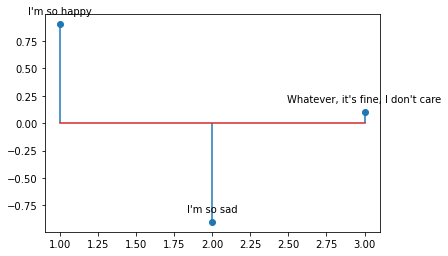

In [14]:
sentences = [
    "I'm so happy",
    "I'm so sad",
    "Whatever, it's fine, I don't care",
]

x = range(1, len(sentences) + 1)
y = [analyze_sentiment(text).document_sentiment.score for text in sentences]

for index, text in enumerate(sentences):
    plt.annotate(text,(x[index],y[index]), textcoords="offset points", xytext=(0,10), ha='center')

plt.stem(x, y)

## Alice in Wonderland

Now let's try it with an entire book!

In [15]:
with open('alice_in_wonderland.txt') as f:
    text = f.read()
    analysis = analyze_sentiment(text)

    print(f"Overall score of the book: {analysis.document_sentiment.score}")

    %store analysis


Overall score of the book: -0.10000000149011612
Stored 'analysis' (AnalyzeSentimentResponse)


<StemContainer object of 3 artists>

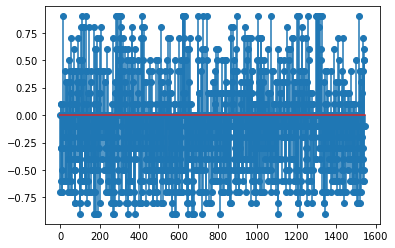

In [16]:
x = range(0, len(analysis.sentences))
y = [sentence.sentiment.score for sentence in analysis.sentences]

plt.stem(x, y)

Let's try to find a "less chaotic" version of the data.

Lower frequencies of a signal usually represent the main structure of the function.

<img src="imgs/fft.png" width="600" />

Example from: https://ipython-books.github.io/

So, let's apply a simple filter to the book signal.

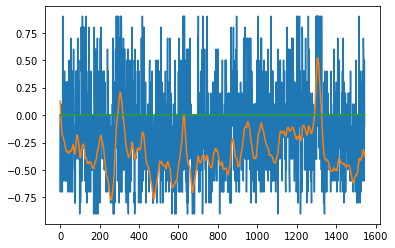

In [17]:
from scipy.signal import butter, filtfilt

b, a = butter(1, 0.02, btype='low', analog=False)
y_filtered = filtfilt(b, a, y) * 3

plt.plot(x, y)
plt.plot(x, y_filtered)
plt.plot(x, [0 for _ in x])

plt.show()

Where are these "happy places" happening in the story?

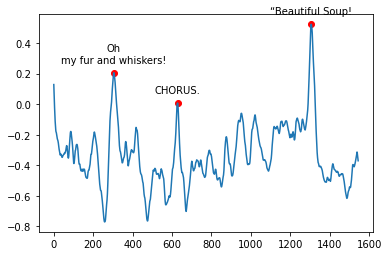

In [18]:
happy_points = []

for index, point in enumerate(y_filtered):
    # Check if the point is above its neighbors
    if index == 0:
            continue
    if index == len(y_filtered) - 1:
        continue
    if y_filtered[index + 1] < point and y_filtered[index - 1]< point:
            happy_points.append(point)

happy_points = sorted(happy_points, reverse=True)[0:3]

happy_places = [np.where(y_filtered == point)[0][0] for point in happy_points]

plt.plot(x, y_filtered)
plt.scatter(happy_places, happy_points, c='red')

sentences = [analysis.sentences[index].text.content for index in happy_places]

for index, text in enumerate(sentences):
    plt.annotate(text,(happy_places[index],happy_points[index]), textcoords="offset points", xytext=(0,10), ha='center')

plt.show()

## Training Wekinator

OSC: Open Sound Control, to communicate with both Wekinator and Max.

https://pypi.org/project/python-osc/

And also the messages needed to control wekinator from python can be found here:

http://www.wekinator.org/detailed-instructions/#3_Record_some_training_examples

We'll be sending these combinatios of chords and sentiment score to Wekinator for training.

The chord notation follows the octave.pitch class, specified here:

http://rtcmix.org/reference/scorefile/midipch.php


#### Wekinator Inputs:

<ol>
    <li>Sentiment score</li>
    <li>key (t - 3)</li>
    <li>key (t - 2)</li>
    <li>key (t - 1)</li>
</ol>

#### Wekinator Outputs:

<ol>
    <li>Key (t)</li>
    <li>Chord[0]</li>
    <li>Chord[1]</li>
    <li>Chord[2]</li>
    <li>Chord[3]</li>
    <li>Chord[4]</li>
</ol>

In [49]:
import random

def semitones(key):
    cad2up = 2.0
    cad3up = cad2up + 2.0
    cad4up = cad3up + 1.0
    cad5up = cad4up + 2.0
    cad6up = cad5up + 2.0
    cad7up = cad6up + 2.0

    cad_up = [0.0, cad2up, cad3up, cad4up, cad5up, cad6up, cad7up]
    return cad_up[key]

chords = [
    # Initial
    ([0.9, semitones(1), semitones(1), semitones(1)], [6.0, 8.0, 8.04, 8.07, 9.0, semitones(5)]),
    ([-0.9, semitones(1), semitones(1), semitones(1)], [6.0, 8.0, 8.04, 8.07, 9.0, semitones(5)]),
    ([0.0, semitones(1), semitones(1), semitones(1)], [6.0, 8.0, 8.04, 8.07, 9.0, semitones(5)]),

    # Score 0.9, progression I-IV-V -> I
    ([0.9, semitones(1), semitones(4), semitones(5)], [6.0, 8.0, 8.04, 8.07, 9.0, semitones(1)]),
    # Score 0.7, progression II-V-I -> I
    ([0.7, semitones(2), semitones(5), semitones(1)], [6.0, 8.0, 8.04, 8.07, 9.0, semitones(4)]),
    # Score 0.6, progression I-V-VI -> IV
    ([0.6, semitones(1), semitones(5), semitones(6)], [6.0, 8.0, 8.04, 8.07, 9.0, semitones(4)]),

    # Cannon, progression I-V-VI -> III
    ([0.1, semitones(1), semitones(5), semitones(6)], [6.0, 8.0, 8.04, 8.07, 9.0, semitones(3)]),
    # Cannon, progression V-VI-III -> IV
    ([0.1, semitones(5), semitones(6), semitones(3)], [6.0, 8.0, 8.04, 8.07, 9.0, semitones(4)]),
    # Cannon, progression VI-III-IV -> I
    ([0.1, semitones(6), semitones(3), semitones(4)], [6.0, 8.0, 8.04, 8.07, 9.0, semitones(1)]),
    # Cannon, progression III-IV-I -> IV
    ([0.1, semitones(3), semitones(4), semitones(1)], [6.0, 8.0, 8.04, 8.07, 9.0, semitones(4)]),
    # Cannon, progression IV-I-IV -> V
    ([0.1, semitones(4), semitones(1), semitones(4)], [6.0, 8.0, 8.04, 8.07, 9.0, semitones(5)]),

    # Score 0.2, progression I-VI-IV -> V
    ([0.2, semitones(1), semitones(6), semitones(4)], [6.0, 8.0, 8.04, 8.07, 9.0, semitones(5)]),
    # Score 0.1, progression VI-IV-I -> V
    ([0.1, semitones(6), semitones(4), semitones(1)], [6.0, 8.0, 8.04, 8.07, 9.0, semitones(5)]),
    # Score 0.2, progression I-III-IV -> VI
    ([0.2, semitones(1), semitones(3), semitones(4)], [6.0, 8.0, 8.04, 8.07, 9.0, semitones(6)]),


    # Chaotic progression, minor scale
    ([-0.3, semitones(1), semitones(4), semitones(5)], [6.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 9.0 + random.random(), semitones(1)]),
    ([-0.4, semitones(2), semitones(5), semitones(1)], [6.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 9.0 + random.random(), semitones(2)]),
    ([-0.5, semitones(1), semitones(5), semitones(6)], [6.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 9.0 + random.random(), semitones(3)]),

    ([-0.6, semitones(1), semitones(5), semitones(6)], [6.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 9.0 + random.random(), semitones(4)]),
    ([-0.6, semitones(5), semitones(6), semitones(3)], [6.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 9.0 + random.random(), semitones(5)]),
    ([-0.6, semitones(6), semitones(3), semitones(4)], [6.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 9.0 + random.random(), semitones(6)]),
    ([-0.6, semitones(3), semitones(4), semitones(1)], [6.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 9.0 + random.random(), semitones(4)]),
    ([-0.6, semitones(4), semitones(1), semitones(4)], [6.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 9.0 + random.random(), semitones(3)]),

    ([-0.2, semitones(1), semitones(6), semitones(4)], [6.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 9.0 + random.random(), semitones(2)]),
    ([-0.1, semitones(6), semitones(4), semitones(1)], [6.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 9.0 + random.random(), semitones(3)]),
    ([-0.2, semitones(1), semitones(3), semitones(4)], [6.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 9.0 + random.random(), semitones(6)]),

    # Chaotic progression, diminished scale
    ([-0.3, semitones(1), semitones(4), semitones(5)], [6.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 9.0 + random.random(), semitones(1)]),
    ([-0.4, semitones(2), semitones(5), semitones(1)], [6.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 9.0 + random.random(), semitones(2)]),
    ([-0.5, semitones(1), semitones(5), semitones(6)], [6.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 9.0 + random.random(), semitones(3)]),

    ([-0.6, semitones(1), semitones(5), semitones(6)], [6.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 9.0 + random.random(), semitones(3)]),
    ([-0.6, semitones(5), semitones(6), semitones(3)], [6.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 9.0 + random.random(), semitones(4)]),
    ([-0.6, semitones(6), semitones(3), semitones(4)], [6.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 9.0 + random.random(), semitones(6)]),
    ([-0.6, semitones(3), semitones(4), semitones(1)], [6.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 9.0 + random.random(), semitones(4)]),
    ([-0.6, semitones(4), semitones(1), semitones(4)], [6.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 9.0 + random.random(), semitones(2)]),

    ([-0.2, semitones(1), semitones(6), semitones(4)], [6.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 9.0 + random.random(), semitones(2)]),
    ([-0.1, semitones(6), semitones(4), semitones(1)], [6.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 9.0 + random.random(), semitones(1)]),
    ([-0.2, semitones(1), semitones(3), semitones(4)], [6.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 9.0 + random.random(), semitones(3)]),

    # Chaotic progression, augmented scale
    ([-0.5, semitones(1), semitones(4), semitones(5)], [6.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 9.0 + random.random(), semitones(1)]),
    ([-0.6, semitones(2), semitones(5), semitones(1)], [6.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 9.0 + random.random(), semitones(2)]),
    ([-0.7, semitones(1), semitones(5), semitones(6)], [6.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 9.0 + random.random(), semitones(3)]),

    ([-0.7, semitones(1), semitones(5), semitones(6)], [6.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 9.0 + random.random(), semitones(3)]),
    ([-0.7, semitones(5), semitones(6), semitones(3)], [6.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 9.0 + random.random(), semitones(4)]),
    ([-0.7, semitones(6), semitones(3), semitones(4)], [6.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 9.0 + random.random(), semitones(5)]),
    ([-0.7, semitones(3), semitones(4), semitones(1)], [6.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 9.0 + random.random(), semitones(6)]),
    ([-0.7, semitones(4), semitones(1), semitones(4)], [6.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 9.0 + random.random(), semitones(2)]),

    ([-0.4, semitones(1), semitones(6), semitones(4)], [6.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 9.0 + random.random(), semitones(2)]),
    ([-0.3, semitones(6), semitones(4), semitones(1)], [6.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 9.0 + random.random(), semitones(2)]),
    ([-0.4, semitones(1), semitones(3), semitones(4)], [6.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 9.0 + random.random(), semitones(1)]),


    # Chaotic everything
    ([-0.3, semitones(1), semitones(4), semitones(5)], [6.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 9.0 + random.random(), semitones(1)]),
    ([-0.4, semitones(2), semitones(5), semitones(1)], [6.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 9.0 + random.random(), semitones(2)]),
    ([-0.5, semitones(1), semitones(5), semitones(6)], [6.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 9.0 + random.random(), semitones(3)]),

    ([-0.6, semitones(1), semitones(5), semitones(6)], [6.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 9.0 + random.random(), semitones(4)]),
    ([-0.6, semitones(5), semitones(6), semitones(3)], [6.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 9.0 + random.random(), semitones(5)]),
    ([-0.6, semitones(6), semitones(3), semitones(4)], [6.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 9.0 + random.random(), semitones(6)]),
    ([-0.6, semitones(3), semitones(4), semitones(1)], [6.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 9.0 + random.random(), semitones(4)]),
    ([-0.6, semitones(4), semitones(1), semitones(4)], [6.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 9.0 + random.random(), semitones(3)]),

    ([-0.2, semitones(1), semitones(6), semitones(4)], [6.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 9.0 + random.random(), semitones(2)]),
    ([-0.1, semitones(6), semitones(4), semitones(1)], [6.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 9.0 + random.random(), semitones(3)]),
    ([-0.2, semitones(1), semitones(3), semitones(4)], [6.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 9.0 + random.random(), semitones(6)]),

    # Chaotic everything
    ([-0.3, semitones(1), semitones(4), semitones(5)], [6.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 9.0 + random.random(), semitones(1)]),
    ([-0.4, semitones(2), semitones(5), semitones(1)], [6.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 9.0 + random.random(), semitones(2)]),
    ([-0.5, semitones(1), semitones(5), semitones(6)], [6.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 9.0 + random.random(), semitones(3)]),

    ([-0.6, semitones(1), semitones(5), semitones(6)], [6.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 9.0 + random.random(), semitones(3)]),
    ([-0.6, semitones(5), semitones(6), semitones(3)], [6.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 9.0 + random.random(), semitones(4)]),
    ([-0.6, semitones(6), semitones(3), semitones(4)], [6.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 9.0 + random.random(), semitones(6)]),
    ([-0.6, semitones(3), semitones(4), semitones(1)], [6.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 9.0 + random.random(), semitones(4)]),
    ([-0.6, semitones(4), semitones(1), semitones(4)], [6.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 9.0 + random.random(), semitones(2)]),

    ([-0.2, semitones(1), semitones(6), semitones(4)], [6.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 9.0 + random.random(), semitones(2)]),
    ([-0.1, semitones(6), semitones(4), semitones(1)], [6.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 9.0 + random.random(), semitones(1)]),
    ([-0.2, semitones(1), semitones(3), semitones(4)], [6.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 9.0 + random.random(), semitones(3)]),

    # Chaotic everything
    ([-0.5, semitones(1), semitones(4), semitones(5)], [6.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 9.0 + random.random(), semitones(1)]),
    ([-0.6, semitones(2), semitones(5), semitones(1)], [6.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 9.0 + random.random(), semitones(2)]),
    ([-0.7, semitones(1), semitones(5), semitones(6)], [6.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 9.0 + random.random(), semitones(3)]),

    ([-0.7, semitones(1), semitones(5), semitones(6)], [6.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 9.0 + random.random(), semitones(3)]),
    ([-0.7, semitones(5), semitones(6), semitones(3)], [6.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 9.0 + random.random(), semitones(4)]),
    ([-0.7, semitones(6), semitones(3), semitones(4)], [6.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 9.0 + random.random(), semitones(5)]),
    ([-0.7, semitones(3), semitones(4), semitones(1)], [6.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 9.0 + random.random(), semitones(6)]),
    ([-0.7, semitones(4), semitones(1), semitones(4)], [6.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 9.0 + random.random(), semitones(2)]),

    ([-0.4, semitones(1), semitones(6), semitones(4)], [6.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 9.0 + random.random(), semitones(2)]),
    ([-0.3, semitones(6), semitones(4), semitones(1)], [6.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 9.0 + random.random(), semitones(2)]),
    ([-0.4, semitones(1), semitones(3), semitones(4)], [6.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 8.0 + random.random(), 9.0 + random.random(), semitones(1)]),
]

In [50]:
from osc4py3.as_eventloop import *
from osc4py3 import oscbuildparse
from pythonosc import udp_client

import time

# To communicate with Wekinator (default wek port 6448)
wekinator = udp_client.SimpleUDPClient("127.0.0.1", 6448)

# Send the message to wekinator to start recording
wekinator.send_message("/wekinator/control/startRecording", True)

for input, chord in chords:
    # Set the output of wekinator to the chord
    wekinator.send_message("/wekinator/control/outputs", chord)

    # Send the score as input of wekinator
    wekinator.send_message("/wek/inputs", input)

# Stop recording
wekinator.send_message("/wekinator/control/stopRecording", True)

# Train!
wekinator.send_message("/wekinator/control/train", True)


In [51]:
# Start the system
osc_startup()

# Progression array
progression = [semitones(1), semitones(1), semitones(1)]

# Function to alert of incomming message, received from wekinator
message = False
def handlerfunction(p, ch0, ch1, ch2, ch3, ch4):
    global progression
    progression.append(int(p))

    global message
    message = True

osc_udp_server("127.0.0.1", 12000, "aservername")
osc_method("/wek/outputs", handlerfunction)

# Start Wekinator
wekinator.send_message("/wekinator/control/startRunning", True)

for t, score in enumerate(y_filtered):

    # Avoid being out of index
    if t > len(y_filtered) - 3:
        progression.append(semitones(1))
    if t > len(y_filtered) - 2:
        progression.append(semitones(1))
    if t > len(y_filtered) - 1:
        progression.append(semitones(1))

    # Add previous progressions
    input = [score, progression[t], progression[t + 1], progression[t + 2]]

    # Send the input message
    wekinator.send_message("/wek/inputs", input)

    time.sleep(0.1)
    
    # Wait for a new response message
    message = False
    while(not message):
        osc_process()
        
        if error_counter > 9999:
            message = True
        error_counter = error_counter + 1

osc_terminate()

# Stop Wekinator
wekinator.send_message("/wekinator/control/stopRunning", True)

## Concert

Play the entire filtered text of Alice in Wonderland, each sentence at a time. The logic is the following:

<ol>
    <li>The conductor sends the signal to start Max</li>
    <li>For each sentence in the analysis: send the score to wekinator and wekinator outputs the result chord to Max.</li>
</ol>

The length of each note (given by time.sleep()) depends on the length of the sentence.

In [53]:
# To communicate with Max (port 12001)
conductor = udp_client.SimpleUDPClient("127.0.0.1", 12001)

# Start Max
conductor.send_message("/conductor/start", True)

# Start Wekinator
wekinator.send_message("/wekinator/control/startRunning", True)

# Find the max len of all sentences and normalize everything to 1s.
max_l = 0
for sentence in analysis.sentences:
    l = len(sentence.text.content)

    if l > max_l: max_l = l

for t, score in enumerate(y_filtered):

    # Add previous progressions
    input = [score, progression[t], progression[t + 1], progression[t + 2]]

    # Send to Wekinator
    wekinator.send_message("/wek/inputs", input)

    l = len(analysis.sentences[t].text.content)
    time.sleep(l / max_l)

# Stop Wekinator
wekinator.send_message("/wekinator/control/stopRunning", True)